<a href="https://colab.research.google.com/github/venkat-krish/basics_tensorflow/blob/master/Basic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

In [34]:
from __future__ import absolute_import, division, print_function, unicode_literals

%tensorflow_version 2.x

import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling 
import tensorflow_docs.plots

2.1.0


## The Auto MPG dataset

The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/auto+mpg)

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

dataset_path

32768/30286 [================================] - 0s 1us/step


'/root/.keras/datasets/auto-mpg.data'

In [3]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values="?", comment="\t", sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Clean the data

In [4]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [0]:
dataset = dataset.dropna()

In [0]:
dataset.tail()

origin = dataset.pop('Origin') 

In [0]:
dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0

In [8]:
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1.0,0.0,0.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1.0,0.0,0.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1.0,0.0,0.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1.0,0.0,0.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1.0,0.0,0.0


### Split the data into test and train

In [0]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

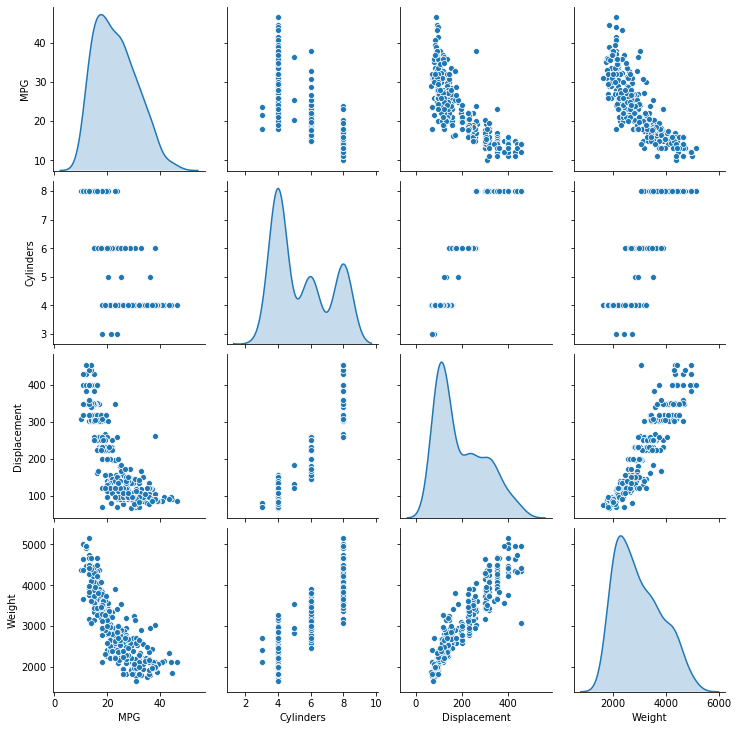

In [15]:
# Inspect the dadta
sns.pairplot(train_dataset[['MPG', 'Cylinders','Displacement', 'Weight']], diag_kind='kde')

In [16]:
print(train_dataset.columns)

Index(['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'Model Year', 'USA', 'Europe', 'Japan'],
      dtype='object')


### Split features from the labels


In [0]:
# look at the statistics
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

In [18]:
train_stats = train_dataset.describe()
# train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### Normalizing the data


In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [21]:
normed_train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,2.093159e-16,1.0,-1.457657,-0.869348,-0.869348,1.483887,1.483887
Displacement,314.0,1.018294e-16,1.0,-1.220325,-0.860894,-0.424785,0.675074,2.489002
Horsepower,314.0,-1.909301e-17,1.0,-1.545283,-0.751241,-0.272190,0.607162,3.153347
Weight,314.0,-9.723291e-17,1.0,-1.589352,-0.869478,-0.198782,0.732017,2.547401
Acceleration,314.0,2.688832e-15,1.0,-2.710152,-0.630725,-0.021237,0.588250,3.313017
Model Year,314.0,9.561531e-16,1.0,-1.604642,-0.788458,0.027726,0.843910,1.660094
USA,314.0,6.081476e-17,1.0,-1.286751,-1.286751,0.774676,0.774676,0.774676
Europe,314.0,8.485781e-18,1.0,-0.465148,-0.465148,-0.465148,-0.465148,2.143005
Japan,314.0,3.164489e-17,1.0,-0.495225,-0.495225,-0.495225,-0.495225,2.012852


## Build the model

Let's build the model. Here, we'll use `Sequential` model with two densely connected hidden layers.


In [25]:
# print(len(train_dataset.keys()))

def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)                            
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse', 
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  
  return model

9


In [26]:
model = build_model()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


Take the mini-batch as 10 and train the model.

In [27]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.0227934 ],
       [ 0.07673004],
       [ 0.53927773],
       [-0.01361743],
       [-0.08867239],
       [ 0.01850131],
       [-0.06949541],
       [-0.00631899],
       [-0.03284029],
       [ 0.05556324]], dtype=float32)

#### Train the model

In [35]:
EPOCHS = 1000

history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split=0.2, verbose=0,
    callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:563.3122,  mae:22.4330,  mse:563.3122,  val_loss:555.8338,  val_mae:22.2291,  val_mse:555.8338,  
....................................................................................................
Epoch: 100, loss:6.1286,  mae:1.7261,  mse:6.1286,  val_loss:7.5509,  val_mae:2.0497,  val_mse:7.5509,  
....................................................................................................
Epoch: 200, loss:5.3640,  mae:1.5740,  mse:5.3640,  val_loss:7.8547,  val_mae:2.1400,  val_mse:7.8547,  
....................................................................................................
Epoch: 300, loss:4.7073,  mae:1.4510,  mse:4.7073,  val_loss:7.8422,  val_mae:2.0875,  val_mse:7.8422,  
....................................................................................................
Epoch: 400, loss:4.3724,  mae:1.3684,  mse:4.3724,  val_loss:7.8289,  val_mae:2.0406,  val_mse:7.8289,  
..............................................................

Visualizing the model's training progress using the stats stored in the history object

In [37]:
hist = pd.DataFrame(history.history)
hist['epochs'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epochs
995,2.364260,1.003737,2.364260,8.021157,2.208198,8.021157,995
996,2.171814,0.953707,2.171814,7.716311,2.177449,7.716311,996
997,2.151172,0.945147,2.151172,7.840083,2.196121,7.840084,997
998,2.402455,1.030609,2.402455,7.693300,2.161077,7.693300,998
999,2.211317,0.954480,2.211317,8.214314,2.257654,8.214314,999


In [0]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

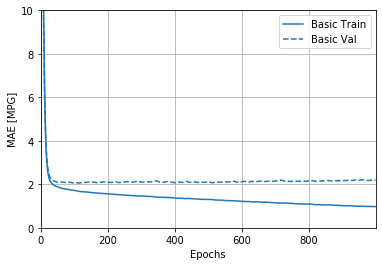

In [39]:
plotter.plot({'Basic': history}, metric='mae')
plt.ylim([0,10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MAE [MPG^2]')

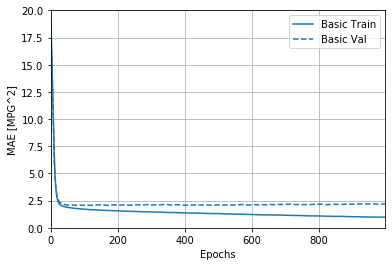

In [41]:
plotter.plot({'Basic': history}, metric='mae')
plt.ylim([0,20])
plt.ylabel('MAE [MPG^2]')

This graph shows little improvement, or even degradation in the validation error after about 100 epochs. Let's update the model.fit call to automatically stop training when the validation score doesn't improve. We'll use an `EarlyStopping callback` that tests a training condition for every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training

In [43]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                          epochs=EPOCHS, validation_split=0.2, verbose=0,
                          callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:580.4777,  mae:22.8380,  mse:580.4777,  val_loss:573.7750,  val_mae:22.6831,  val_mse:573.7750,  
..............................................................

Text(0, 0.5, 'MAE [MPG]')

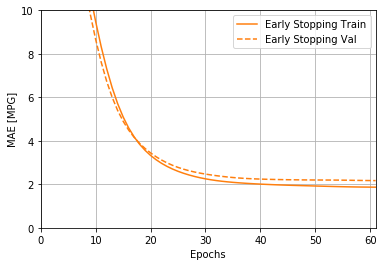

In [44]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [48]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 5.6750 - mae: 1.8279 - mse: 5.6750
Testing set Mean Abs Error:  1.83 MPG


#### Make prediction

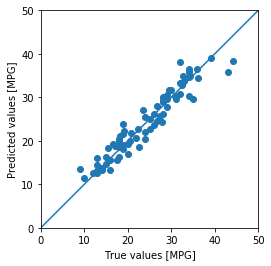

In [54]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values [MPG]')
plt.ylabel('Predicted values [MPG]')
lims = [0,50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

Error and prediction plot

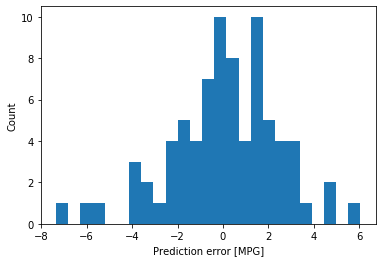

In [55]:
error = test_predictions - test_labels

plt.hist(error, bins=25)
plt.xlabel("Prediction error [MPG]")
_ = plt.ylabel("Count")